<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-functions,-packages,-and-data" data-toc-modified-id="Load-functions,-packages,-and-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load functions, packages, and data</a></span></li><li><span><a href="#Creating-10-portfolio-ranking-after-capital-ratio" data-toc-modified-id="Creating-10-portfolio-ranking-after-capital-ratio-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Creating 10 portfolio ranking after capital ratio</a></span><ul class="toc-item"><li><span><a href="#Tier-1-ratio-sorting" data-toc-modified-id="Tier-1-ratio-sorting-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Tier 1 ratio sorting</a></span></li><li><span><a href="#Book-Equity-ratio" data-toc-modified-id="Book-Equity-ratio-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Book Equity ratio</a></span></li><li><span><a href="#Tier-1-/-Risk-weighted-asset-ratio" data-toc-modified-id="Tier-1-/-Risk-weighted-asset-ratio-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Tier 1 / Risk weighted asset ratio</a></span></li><li><span><a href="#Save-to-pickle" data-toc-modified-id="Save-to-pickle-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Save to pickle</a></span></li></ul></li><li><span><a href="#Table-3---Panel-A" data-toc-modified-id="Table-3---Panel-A-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Table 3 - Panel A</a></span></li><li><span><a href="#Tabel---Panel-B" data-toc-modified-id="Tabel---Panel-B-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Tabel - Panel B</a></span></li><li><span><a href="#Piecewise-regression---Tier-1-ratio" data-toc-modified-id="Piecewise-regression---Tier-1-ratio-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Piecewise regression - Tier 1 ratio</a></span></li><li><span><a href="#Piecewise-reg---plot-(theoretical)" data-toc-modified-id="Piecewise-reg---plot-(theoretical)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Piecewise reg - plot (theoretical)</a></span></li></ul></div>

## Load functions, packages, and data

In [1]:
"Beta function for rolling backward beta"

def market_beta(X,Y,min_win,max_win):
    """ 
    X = The independent variable which is the Market
    Y = The dependent variable which is the Stock
    min_win = minimum length of the window
    max_win = maximum length of the window
    
    It returns the alphas and the betas of
    the rolling regression
    """
    
    # all the observations
    obs = len(X)
    
    # initiate the betas with null values
    betas = np.full(obs, np.nan)
    
    # initiate the alphas with null values
    alphas = np.full(obs, np.nan)
    
    
    regressor = LinearRegression()
    for i in range(min_win,obs,1):
        if i <= max_win: #to get the expanding window
            if np.isnan(Y.to_numpy()[1 : i+1].astype('float')).sum() > 0: #if missing values in the window then pass
                pass
            else:
                regressor.fit(X.to_numpy()[1 : i+1].reshape(-1,1), Y.to_numpy()[1: i+1])
                betas[i]  = regressor.coef_[0]
                alphas[i]  = regressor.intercept_
        else: #the rolling window when periode = max window
            if np.isnan(Y.to_numpy()[i-max_win : i+1].astype('float')).sum() > 0:
                pass
            else:
                regressor.fit(X.to_numpy()[i-max_win : i+1].reshape(-1,1), Y.to_numpy()[i-max_win : i+1])
                betas[i]  = regressor.coef_[0]
                alphas[i]  = regressor.intercept_
        
    return pd.DataFrame({'Alpha': alphas, 'Beta': betas})

In [2]:
%load_ext autoreload
%autoreload 2

"""
Load relevant packages 
"""
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import pandas_datareader as pdr
import datetime
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pickle
from scipy.stats import kurtosis
from scipy.stats import skew
from typing import Union, List
import math as m
from sklearn import datasets, linear_model
import statsmodels.api as sm

In [3]:
"""
Set path to get save data
"""
path = "/Users/julielaustsen/Desktop/OneDrive/UNI/Speciale /Data/Eikon"
os.chdir(path) 

In [4]:
"""
Load saved dataframes and dictionareis
"""
with open('data_calc_win', 'rb') as data_dict_win:
    data_calc_win = pickle.load(data_dict_win) 

with open('regress_calc', 'rb') as regress: #load backward beta
    regress_calc = pickle.load(regress)
    
with open('regress_calc_for', 'rb') as regress_for: #load forward beta
    regress_calc_for = pickle.load(regress_for)
    
with open('df_mkt', 'rb') as data_market_df:
    df_mkt = pickle.load(data_market_df)

In [5]:
"""
To get the same columns names in each dataframe
"""
columns_list = ['Market Value', 'Return', 'Excess Return', 'Book Equity', 'Book Leverage ratio', 'Book Equity ratio', 'Book Equity/RWA', 'Tier 1 ratio','Tier 1/RWA','Total Assets','Total Risk Weighted Assets']

for i in data_calc_win.keys():
    data_calc_win[i].columns = columns_list

## Creating 10 portfolio ranking after capital ratio

In [6]:
"""
Create dataframes that containes all our capital ratios. We are working with three
1. Book Equity ratio
2. Tier 1 ratio
3. Tier 1 / Risk weighted assets
"""

BER = pd.concat([data_calc_win[i]['Book Equity ratio'] for i in list(data_calc_win.keys())], axis=1)
T1R = pd.concat([data_calc_win[i]['Tier 1 ratio'] for i in list(data_calc_win.keys())], axis=1)
T1RWA = pd.concat([data_calc_win[i]['Tier 1/RWA'] for i in list(data_calc_win.keys())], axis=1)

BER.columns = list(data_calc_win.keys())
T1R.columns = list(data_calc_win.keys())
T1RWA.columns = list(data_calc_win.keys())

### Tier 1 ratio sorting

In [7]:
"""
Tier 1 ratio sorting banks into group 
"""

group1, group2, group3, group4, group5, group6, group7, group8, group9, group10 = {},{},{},{},{},{},{},{},{},{}

no_obs_T1R = T1R.shape[0]

for i in range(no_obs_T1R):
        no_T1R = T1R.iloc[i,:].count()
        no_group1, no_group2, no_group3, no_group4, no_group5, no_group6, no_group7, no_group8, no_group9 = m.floor(no_T1R*0.1), m.floor(no_T1R*0.1), m.floor(no_T1R*0.1), m.floor(no_T1R*0.1), m.floor(no_T1R*0.1), m.floor(no_T1R*0.1), m.floor(no_T1R*0.1), m.floor(no_T1R*0.1), m.floor(no_T1R*0.1)
        no_group10 = no_T1R - (no_group1 + no_group2 + no_group3 + no_group4 + no_group5 + no_group6 + no_group7 + no_group8 + no_group9)
        
        group1[i]=list(T1R.iloc[i,:].sort_values()[:no_group1].index)
        group2[i]=list(T1R.iloc[i,:].sort_values()[no_group1:no_group1+no_group2].index)
        group3[i]=list(T1R.iloc[i,:].sort_values()[no_group1+no_group2:no_group1+no_group2+no_group3].index)
        group4[i]=list(T1R.iloc[i,:].sort_values()[no_group1+no_group2+no_group3:no_group1+no_group2+no_group3+no_group4].index)        
        group5[i]=list(T1R.iloc[i,:].sort_values()[no_group1+no_group2+no_group3+no_group4:no_group1+no_group2+no_group3+no_group4+no_group5].index)
        group6[i]=list(T1R.iloc[i,:].sort_values()[no_group1+no_group2+no_group3+no_group4+no_group5:no_group1+no_group2+no_group3+no_group4+no_group5+no_group6].index)
        group7[i]=list(T1R.iloc[i,:].sort_values()[no_group1+no_group2+no_group3+no_group4+no_group5+no_group6:no_group1+no_group2+no_group3+no_group4+no_group5+no_group6+no_group7].index)
        group8[i]=list(T1R.iloc[i,:].sort_values()[no_group1+no_group2+no_group3+no_group4+no_group5+no_group6+no_group7:no_group1+no_group2+no_group3+no_group4+no_group5+no_group6+no_group7+no_group8].index)
        group9[i]=list(T1R.iloc[i,:].sort_values()[no_group1+no_group2+no_group3+no_group4+no_group5+no_group6+no_group7+no_group8:no_group1+no_group2+no_group3+no_group4+no_group5+no_group6+no_group7+no_group8+no_group9].index)
        group10[i]=list(T1R.iloc[i,:].sort_values()[no_group1+no_group2+no_group3+no_group4+no_group5+no_group6+no_group7+no_group8+no_group9:no_T1R].index)

In [8]:
#No of observations
print(np.nansum(T1R.count()))
print(T1R.shape[0]*T1R.shape[1])

32956
62376


In [9]:
"""
Creating a dictionary that contains the group sorting of tier 1 ratio
"""
group_dict = {}
group_dict[0] = group1
group_dict[1] = group2
group_dict[2] = group3
group_dict[3] = group4
group_dict[4] = group5
group_dict[5] = group6
group_dict[6] = group7
group_dict[7] = group8
group_dict[8] = group9
group_dict[9] = group10

In [10]:
"""
Assigning values to each timestep to each group (Tier 1 ratio sorting)
"""

dict_T1R = {}

for g in group_dict.keys():
    dict_T1R[g] = {}
    
    for i in group_dict[g].keys():
        df = pd.DataFrame(columns=group_dict[g][i])
        for j in df.columns:
            s1 = data_calc_win[j].iloc[i,0].copy() #market value
            s2 = data_calc_win[j].iloc[i,2].copy() #excess return
            s3 = data_calc_win[j].iloc[i,7].copy() #Tier 1 ratio
            df[j] = [s1,s2,s3]
        dict_T1R[g][i] = df.T
        dict_T1R[g][i].columns = ['Market value', 'Excess return', 'Tier 1 ratio']

In [11]:
"""
Calculate weight, equal & value weighted excess returns and tier 1 ratio for each of the 10 groups
"""
#assigning weights
for i in dict_T1R.keys():
    for j in range(len(dict_T1R[i])):
        dict_T1R[i][j]['weight'] = dict_T1R[i][j].iloc[:,0]/(dict_T1R[i][j]['Market value'].sum())

#calculating weighted excess returns and tier 1 ratio
T1R_val = {}

for i in dict_T1R.keys():
    T1R_val[i] = pd.DataFrame(columns=['ew_excess_ret', 'ew_Tier_1_ratio', 'vw_excess_ret', 'vw_Tier_1_ratio'])
    for j in range(len(dict_T1R[i])):
            T1R_val[i].loc[j,'ew_excess_ret'] = (dict_T1R[i][j]['Excess return']*(1/len(dict_T1R[i][j]))).sum()
            T1R_val[i].loc[j,'ew_Tier_1_ratio'] = (dict_T1R[i][j]['Tier 1 ratio']*(1/len(dict_T1R[i][j]))).sum()
            T1R_val[i].loc[j,'vw_excess_ret'] = (dict_T1R[i][j]['Excess return']*dict_T1R[i][j]['weight']).sum()
            T1R_val[i].loc[j,'vw_Tier_1_ratio'] = (dict_T1R[i][j]['Tier 1 ratio']*dict_T1R[i][j]['weight']).sum()


### Book Equity ratio

In [12]:
"""
Book Equity ratio sorting banks into group 
"""

group1, group2, group3, group4, group5, group6, group7, group8, group9, group10 = {},{},{},{},{},{},{},{},{},{}

no_obs_BER = BER.shape[0]

for i in range(no_obs_BER):
        no_BER = BER.iloc[i,:].count()
        no_group1, no_group2, no_group3, no_group4, no_group5, no_group6, no_group7, no_group8, no_group9 = m.floor(no_BER*0.1), m.floor(no_BER*0.1), m.floor(no_BER*0.1), m.floor(no_BER*0.1), m.floor(no_BER*0.1), m.floor(no_BER*0.1), m.floor(no_BER*0.1), m.floor(no_BER*0.1), m.floor(no_BER*0.1)
        no_group10 = no_BER - (no_group1 + no_group2 + no_group3 + no_group4 + no_group5 + no_group6 + no_group7 + no_group8 + no_group9)
        
        group1[i]=list(BER.iloc[i,:].sort_values()[:no_group1].index)
        group2[i]=list(BER.iloc[i,:].sort_values()[no_group1:no_group1+no_group2].index)
        group3[i]=list(BER.iloc[i,:].sort_values()[no_group1+no_group2:no_group1+no_group2+no_group3].index)
        group4[i]=list(BER.iloc[i,:].sort_values()[no_group1+no_group2+no_group3:no_group1+no_group2+no_group3+no_group4].index)        
        group5[i]=list(BER.iloc[i,:].sort_values()[no_group1+no_group2+no_group3+no_group4:no_group1+no_group2+no_group3+no_group4+no_group5].index)
        group6[i]=list(BER.iloc[i,:].sort_values()[no_group1+no_group2+no_group3+no_group4+no_group5:no_group1+no_group2+no_group3+no_group4+no_group5+no_group6].index)
        group7[i]=list(BER.iloc[i,:].sort_values()[no_group1+no_group2+no_group3+no_group4+no_group5+no_group6:no_group1+no_group2+no_group3+no_group4+no_group5+no_group6+no_group7].index)
        group8[i]=list(BER.iloc[i,:].sort_values()[no_group1+no_group2+no_group3+no_group4+no_group5+no_group6+no_group7:no_group1+no_group2+no_group3+no_group4+no_group5+no_group6+no_group7+no_group8].index)
        group9[i]=list(BER.iloc[i,:].sort_values()[no_group1+no_group2+no_group3+no_group4+no_group5+no_group6+no_group7+no_group8:no_group1+no_group2+no_group3+no_group4+no_group5+no_group6+no_group7+no_group8+no_group9].index)
        group10[i]=list(BER.iloc[i,:].sort_values()[no_group1+no_group2+no_group3+no_group4+no_group5+no_group6+no_group7+no_group8+no_group9:no_BER].index)

In [13]:
#No of observations
print(np.nansum(BER.count()))
print(BER.shape[0]*BER.shape[1])

40548
62376


In [14]:
"""
Creating a dictionary that contains the group sorting of Book Equity ratio
"""
group_dict = {}
group_dict[0] = group1
group_dict[1] = group2
group_dict[2] = group3
group_dict[3] = group4
group_dict[4] = group5
group_dict[5] = group6
group_dict[6] = group7
group_dict[7] = group8
group_dict[8] = group9
group_dict[9] = group10

In [15]:
"""
Assigning values to each timestep to each group (Book Equity ratio sorting)
"""

dict_BER = {}

for g in group_dict.keys():
    dict_BER[g] = {}
    
    for i in group_dict[g].keys():
        df = pd.DataFrame(columns=group_dict[g][i])
        for j in df.columns:
            s1 = data_calc_win[j].iloc[i,0].copy() #market value
            s2 = data_calc_win[j].iloc[i,2].copy() #excess return
            s3 = data_calc_win[j].iloc[i,5].copy() #Book Equity ratio
            df[j] = [s1,s2,s3]
        dict_BER[g][i] = df.T
        dict_BER[g][i].columns = ['Market value', 'Excess return', 'Book Equity ratio']

In [16]:
"""
Calculate weight, equal & value weighted excess returns and book equity ratio for each of the 10 groups
"""
#assigning weights
for i in dict_BER.keys():
    for j in range(len(dict_BER[i])):
        dict_BER[i][j]['weight'] = dict_BER[i][j].iloc[:,0]/(dict_BER[i][j]['Market value'].sum())

#calculating weighted excess returns and Book equity ratio
BER_val = {}

for i in dict_BER.keys():
    BER_val[i] = pd.DataFrame(columns=['ew_excess_ret', 'ew_Book_equity_ratio', 'vw_excess_ret', 'vw_Book_equity_ratio'])
    for j in range(len(dict_BER[i])):
            BER_val[i].loc[j,'ew_excess_ret'] = (dict_BER[i][j]['Excess return']*(1/len(dict_BER[i][j]))).sum()
            BER_val[i].loc[j,'ew_Book_equity_ratio'] = (dict_BER[i][j]['Book Equity ratio']*(1/len(dict_BER[i][j]))).sum()
            BER_val[i].loc[j,'vw_excess_ret'] = (dict_BER[i][j]['Excess return']*dict_BER[i][j]['weight']).sum()
            BER_val[i].loc[j,'vw_Book_equity_ratio'] = (dict_BER[i][j]['Book Equity ratio']*dict_BER[i][j]['weight']).sum()


### Tier 1 / Risk weighted asset ratio

In [17]:
"""
Tier 1/RWA ratio sorting banks into group 
"""

group1, group2, group3, group4, group5, group6, group7, group8, group9, group10 = {},{},{},{},{},{},{},{},{},{}

no_obs_T1RWA = T1RWA.shape[0]

for i in range(no_obs_T1RWA):
        no_T1RWA = T1RWA.iloc[i,:].count()
        no_group1, no_group2, no_group3, no_group4, no_group5, no_group6, no_group7, no_group8, no_group9 = m.floor(no_T1RWA*0.1), m.floor(no_T1RWA*0.1), m.floor(no_T1RWA*0.1), m.floor(no_T1RWA*0.1), m.floor(no_T1RWA*0.1), m.floor(no_T1RWA*0.1), m.floor(no_T1RWA*0.1), m.floor(no_T1RWA*0.1), m.floor(no_T1RWA*0.1)
        no_group10 = no_T1RWA - (no_group1 + no_group2 + no_group3 + no_group4 + no_group5 + no_group6 + no_group7 + no_group8 + no_group9)
        
        group1[i]=list(T1RWA.iloc[i,:].sort_values()[:no_group1].index)
        group2[i]=list(T1RWA.iloc[i,:].sort_values()[no_group1:no_group1+no_group2].index)
        group3[i]=list(T1RWA.iloc[i,:].sort_values()[no_group1+no_group2:no_group1+no_group2+no_group3].index)
        group4[i]=list(T1RWA.iloc[i,:].sort_values()[no_group1+no_group2+no_group3:no_group1+no_group2+no_group3+no_group4].index)        
        group5[i]=list(T1RWA.iloc[i,:].sort_values()[no_group1+no_group2+no_group3+no_group4:no_group1+no_group2+no_group3+no_group4+no_group5].index)
        group6[i]=list(T1RWA.iloc[i,:].sort_values()[no_group1+no_group2+no_group3+no_group4+no_group5:no_group1+no_group2+no_group3+no_group4+no_group5+no_group6].index)
        group7[i]=list(T1RWA.iloc[i,:].sort_values()[no_group1+no_group2+no_group3+no_group4+no_group5+no_group6:no_group1+no_group2+no_group3+no_group4+no_group5+no_group6+no_group7].index)
        group8[i]=list(T1RWA.iloc[i,:].sort_values()[no_group1+no_group2+no_group3+no_group4+no_group5+no_group6+no_group7:no_group1+no_group2+no_group3+no_group4+no_group5+no_group6+no_group7+no_group8].index)
        group9[i]=list(T1RWA.iloc[i,:].sort_values()[no_group1+no_group2+no_group3+no_group4+no_group5+no_group6+no_group7+no_group8:no_group1+no_group2+no_group3+no_group4+no_group5+no_group6+no_group7+no_group8+no_group9].index)
        group10[i]=list(T1RWA.iloc[i,:].sort_values()[no_group1+no_group2+no_group3+no_group4+no_group5+no_group6+no_group7+no_group8+no_group9:no_T1RWA].index)

In [18]:
#No of observations
print(np.nansum(T1RWA.count()))
print(T1RWA.shape[0]*T1RWA.shape[1])

28702
62376


In [19]:
"""
Creating a dictionary that contains the group sorting of Tier 1/RWA ratio
"""
group_dict = {}
group_dict[0] = group1
group_dict[1] = group2
group_dict[2] = group3
group_dict[3] = group4
group_dict[4] = group5
group_dict[5] = group6
group_dict[6] = group7
group_dict[7] = group8
group_dict[8] = group9
group_dict[9] = group10

In [20]:
"""
Assigning values to each timestep to each group (Tier 1/RWA ratio sorting)
"""

dict_T1RWA = {}

for g in group_dict.keys():
    dict_T1RWA[g] = {}
    
    for i in group_dict[g].keys():
        df = pd.DataFrame(columns=group_dict[g][i])
        for j in df.columns:
            s1 = data_calc_win[j].iloc[i,0].copy() #market value
            s2 = data_calc_win[j].iloc[i,2].copy() #excess return
            s3 = data_calc_win[j].iloc[i,8].copy() #Tier 1/RWA ratio
            df[j] = [s1,s2,s3]
        dict_T1RWA[g][i] = df.T
        dict_T1RWA[g][i].columns = ['Market value', 'Excess return', 'Tier 1/RWA ratio']

In [21]:
"""
Calculate weight, equal & value weighted excess returns and Tier 1/RWA ratio for each of the 10 groups
"""
#assigning weights
for i in dict_T1RWA.keys():
    for j in range(len(dict_T1RWA[i])):
        dict_T1RWA[i][j]['weight'] = dict_T1RWA[i][j].iloc[:,0]/(dict_T1RWA[i][j]['Market value'].sum())

#calculating weighted excess returns and Book equity ratio
T1RWA_val = {}

for i in dict_T1RWA.keys():
    T1RWA_val[i] = pd.DataFrame(columns=['ew_excess_ret', 'ew_Tier1/RWA_ratio', 'vw_excess_ret', 'vw_Tier1/RWA_ratio'])
    for j in range(len(dict_T1RWA[i])):
            T1RWA_val[i].loc[j,'ew_excess_ret'] = (dict_T1RWA[i][j]['Excess return']*(1/len(dict_T1RWA[i][j]))).sum()
            T1RWA_val[i].loc[j,'ew_Tier1/RWA_ratio'] = (dict_T1RWA[i][j]['Tier 1/RWA ratio']*(1/len(dict_T1RWA[i][j]))).sum()
            T1RWA_val[i].loc[j,'vw_excess_ret'] = (dict_T1RWA[i][j]['Excess return']*dict_T1RWA[i][j]['weight']).sum()
            T1RWA_val[i].loc[j,'vw_Tier1/RWA_ratio'] = (dict_T1RWA[i][j]['Tier 1/RWA ratio']*dict_T1RWA[i][j]['weight']).sum()



### Save to pickle 

In [22]:
with open('T1R_val', 'wb') as T1R_val_dict: #save Tier 1 ratio portfolios
   pickle.dump(T1R_val, T1R_val_dict)

with open('BER_val', 'wb') as BER_val_dict: #save Book Equity ratio portfolios
   pickle.dump(BER_val, BER_val_dict)

with open('T1RWA_val', 'wb') as T1RWA_val_dict: #save Tier 1/RWA ratio portfolios
   pickle.dump(T1RWA_val, T1RWA_val_dict)

## Table 3 - Panel A 

In [23]:
"""
To create a overview of the 3x10x2 portfolios and recreate panel A
"""

descriptive16 = pd.DataFrame(columns = ['Equal weighted - Book Equity ratio','Value weighted - Book Equity ratio', 'Equal weighted - Tier 1 ratio', 'Value weighted - Tier 1 ratio', 'Equal weighted - Tier 1/Risk weighted assets ratio', 'Value weighted - Tier 1/Risk weighted assets ratio'])

for i in range(10):
    descriptive16.loc[i+1,'Equal weighted - Book Equity ratio'] = round(BER_val[i]['ew_Book_equity_ratio'].median()*100,1)
    descriptive16.loc[i+1,'Equal weighted - Tier 1 ratio'] = round(T1R_val[i]['ew_Tier_1_ratio'].median()*100,1)
    descriptive16.loc[i+1,'Equal weighted - Tier 1/Risk weighted assets ratio'] = round(T1RWA_val[i]['ew_Tier1/RWA_ratio'].median()*100,1)
    descriptive16.loc[i+1,'Value weighted - Book Equity ratio'] = round(BER_val[i]['vw_Book_equity_ratio'].mean()*100,1)
    descriptive16.loc[i+1,'Value weighted - Tier 1 ratio'] = round(T1R_val[i]['vw_Tier_1_ratio'].mean()*100,1)
    descriptive16.loc[i+1,'Value weighted - Tier 1/Risk weighted assets ratio'] = round(T1RWA_val[i]['vw_Tier1/RWA_ratio'].mean()*100,1)
    
#for mean values
descriptive16.loc['10-1','Equal weighted - Book Equity ratio'] = round(descriptive16.iloc[9,0]-descriptive16.iloc[0,0],2)
descriptive16.loc['10-1','Equal weighted - Tier 1 ratio'] = round(descriptive16.iloc[9,1]-descriptive16.iloc[0,1],2)
descriptive16.loc['10-1','Equal weighted - Tier 1/Risk weighted assets ratio'] = round(descriptive16.iloc[9,2]-descriptive16.iloc[0,2],2)
descriptive16.loc['10-1','Value weighted - Book Equity ratio'] = round(descriptive16.iloc[9,3]-descriptive16.iloc[0,3],2)
descriptive16.loc['10-1','Value weighted - Tier 1 ratio'] = round(descriptive16.iloc[9,4]-descriptive16.iloc[0,4],2)
descriptive16.loc['10-1','Value weighted - Tier 1/Risk weighted assets ratio'] = round(descriptive16.iloc[9,5]-descriptive16.iloc[0,5],2)

In [24]:
descriptive16.reset_index(inplace=True)
descriptive16.rename(columns = {'index':'Decile'})

,Decile,Equal weighted - Book Equity ratio,Value weighted - Book Equity ratio,Equal weighted - Tier 1 ratio,Value weighted - Tier 1 ratio,Equal weighted - Tier 1/Risk weighted assets ratio,Value weighted - Tier 1/Risk weighted assets ratio
0,1,3.0,3.4,2.7,2.9,7.3,8.2
1,2,4.2,4.4,3.9,3.9,8.1,9.4
2,3,5.0,5.2,4.5,4.5,9.3,10.0
3,4,5.7,5.9,5.2,5.1,10.3,10.7
4,5,6.4,6.6,5.7,5.6,11.1,11.4
5,6,7.1,7.3,6.4,6.2,12.0,12.1
6,7,8.0,8.3,7.0,6.8,13.0,12.9
7,8,9.6,9.6,8.1,8.0,14.0,13.8
8,9,12.3,12.0,9.7,9.6,15.4,15.2
9,10,20.9,35.4,13.7,15.9,21.5,20.1


## Tabel - Panel B 

In [25]:
"""
Regres backward beta values for the teen portfolios sorted after Tier 1 ratio
"""

regress_calc_T1R = {}

for i in T1R_val.keys():
    regress_calc_T1R[i] = pd.DataFrame()
    regress_calc_T1R[i]['ew_backward_beta'] = market_beta(df_mkt['EUROPE IM (excess)'], T1R_val[i]['ew_excess_ret'],12, 24)['Beta']
    regress_calc_T1R[i]['vw_backward_beta'] = market_beta(df_mkt['EUROPE IM (excess)'], T1R_val[i]['vw_excess_ret'],12, 24)['Beta']                               
    regress_calc_T1R[i] = regress_calc_T1R[i].drop([0,1,2,3,4,5,6,7,8,9,10,11])                                                               

In [26]:
"""
Regres backward beta values for the teen portfolios sorted after book equity ratio
"""

regress_calc_BER = {}

for i in BER_val.keys():
    regress_calc_BER[i] = pd.DataFrame()
    regress_calc_BER[i]['ew_backward_beta'] = market_beta(df_mkt['EUROPE IM (excess)'], BER_val[i]['ew_excess_ret'],12, 24)['Beta']
    regress_calc_BER[i]['vw_backward_beta'] = market_beta(df_mkt['EUROPE IM (excess)'], BER_val[i]['vw_excess_ret'],12, 24)['Beta']                               
    regress_calc_BER[i] = regress_calc_BER[i].drop([0,1,2,3,4,5,6,7,8,9,10,11])                                                                   

In [27]:
"""
Regres backward beta values for the teen portfolios sorted after Tier 1/risk weighted asset ratio
"""

regress_calc_T1RWA = {}

for i in T1RWA_val.keys():
    regress_calc_T1RWA[i] = pd.DataFrame()
    regress_calc_T1RWA[i]['ew_backward_beta'] = market_beta(df_mkt['EUROPE IM (excess)'], T1RWA_val[i]['ew_excess_ret'],12, 24)['Beta']
    regress_calc_T1RWA[i]['vw_backward_beta'] = market_beta(df_mkt['EUROPE IM (excess)'], T1RWA_val[i]['vw_excess_ret'],12, 24)['Beta']                               
    regress_calc_T1RWA[i] = regress_calc_T1RWA[i].drop([0,1,2,3,4,5,6,7,8,9,10,11])                                                                   

In [28]:
"""
To create a overview of the 3x10x2 portfolios' backward beta and recreate panel B
"""
descriptive17 = pd.DataFrame(columns = ['Equal weighted - Book Equity ratio', 'Value weighted - Book Equity ratio', 'Equal weighted - Tier 1 ratio','Value weighted - Tier 1 ratio', 'Equal weighted - Tier 1/Risk weighted assets ratio', 'Value weighted - Tier 1/Risk weighted assets ratio'])

for i in range(10):
    descriptive17.loc[i+1,'Equal weighted - Book Equity ratio'] = round(regress_calc_BER[i]['ew_backward_beta'].mean(),2)
    descriptive17.loc[i+1,'Equal weighted - Tier 1 ratio'] = round(regress_calc_T1R[i]['ew_backward_beta'].mean(),2)
    descriptive17.loc[i+1,'Equal weighted - Tier 1/Risk weighted assets ratio'] = round(regress_calc_T1RWA[i]['ew_backward_beta'].mean(),2)
    descriptive17.loc[i+1,'Value weighted - Book Equity ratio'] = round(regress_calc_BER[i]['vw_backward_beta'].mean(),2)
    descriptive17.loc[i+1,'Value weighted - Tier 1 ratio'] = round(regress_calc_T1R[i]['vw_backward_beta'].mean(),2)
    descriptive17.loc[i+1,'Value weighted - Tier 1/Risk weighted assets ratio'] = round(regress_calc_T1RWA[i]['vw_backward_beta'].mean(),2)
    
#for last row
descriptive17.loc['10-1','Equal weighted - Book Equity ratio'] = round(descriptive17.iloc[9,0]-descriptive17.iloc[0,0],2)
descriptive17.loc['10-1','Equal weighted - Tier 1 ratio'] = round(descriptive17.iloc[9,1]-descriptive17.iloc[0,1],2)
descriptive17.loc['10-1','Equal weighted - Tier 1/Risk weighted assets ratio'] = round(descriptive17.iloc[9,2]-descriptive17.iloc[0,2],2)
descriptive17.loc['10-1','Value weighted - Book Equity ratio'] = round(descriptive17.iloc[9,3]-descriptive17.iloc[0,3],2)
descriptive17.loc['10-1','Value weighted - Tier 1 ratio'] = round(descriptive17.iloc[9,4]-descriptive17.iloc[0,4],2)
descriptive17.loc['10-1','Value weighted - Tier 1/Risk weighted assets ratio'] = round(descriptive17.iloc[9,5]-descriptive17.iloc[0,5],2)

In [29]:
descriptive17.reset_index(inplace=True)
descriptive17.rename(columns = {'index':'Decile'})

,Decile,Equal weighted - Book Equity ratio,Value weighted - Book Equity ratio,Equal weighted - Tier 1 ratio,Value weighted - Tier 1 ratio,Equal weighted - Tier 1/Risk weighted assets ratio,Value weighted - Tier 1/Risk weighted assets ratio
0,1,1.13,1.49,1.24,1.51,0.86,1.0
1,2,1.01,1.24,1.13,1.28,1.03,1.18
2,3,0.95,1.3,1.1,1.07,1.08,1.31
3,4,0.89,1.17,1.09,1.2,1.01,1.29
4,5,0.89,1.05,0.9,1.24,0.94,1.3
5,6,0.82,1.19,0.86,1.09,0.89,1.25
6,7,0.78,1.19,0.72,0.92,0.85,1.17
7,8,0.54,0.86,0.55,0.74,0.83,1.33
8,9,0.5,0.9,0.55,0.9,0.7,1.25
9,10,0.59,1.19,0.48,0.93,0.71,1.17


## Piecewise regression - Tier 1 ratio

In [30]:
"""
Saving data in a new dictionary and calculating invers tier 1 ratio in order to do regression
"""

piece_reg = {}
piece_reg = T1R_val.copy()

for i in piece_reg.keys():
    piece_reg[i]['ew_backward_beta'] = regress_calc_T1R[i]['ew_backward_beta'].copy()
    piece_reg[i]['vw_backward_beta'] = regress_calc_T1R[i]['vw_backward_beta'].copy()
    piece_reg[i]['vw_invers_tier1_ratio'] = 1/piece_reg[i]['vw_Tier_1_ratio'] #calculating invers tier 1 ratio
    piece_reg[i]['ew_invers_tier1_ratio'] = 1/piece_reg[i]['ew_Tier_1_ratio'] #calculating invers tier 1 ratio
    piece_reg[i] = piece_reg[i].drop([0,1,2,3,4,5,6,7,8,9,10,11]) #drop the first 12 obs due to nan values in beta variable
    

In [31]:
"""
Performing piecewise regression on the 10 groups. 
Y = Backward beta
X = Invers Tier 1 ratio 
Both variables are VALUE weighted 
"""

slope_backward = pd.DataFrame()


for i in piece_reg.keys():
    Y = piece_reg[i]['vw_backward_beta'].tolist()
    X = piece_reg[i]['vw_invers_tier1_ratio'].tolist() 
    result = sm.OLS(Y, X).fit()
    slope_backward.loc['Slope',i+1] = '{:,.03f}'.format(result.params[0])
    slope_backward.loc['P-value',i+1] = '{:,.03f}'.format(result.pvalues[0])

slope_backward

,1,2,3,4,5,6,7,8,9,10
Slope,0.040,0.048,0.047,0.059,0.068,0.065,0.062,0.059,0.088,0.135
P-value,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [32]:
"""
Performing piecewise regression on the 10 groups. 
Y = Backward beta
X = Invers Tier 1 ratio 
Both variables are EQUAL weighted 
"""

slope_backward2 = pd.DataFrame()


for i in piece_reg.keys():
    Y = piece_reg[i]['ew_backward_beta'].tolist()
    X = piece_reg[i]['ew_invers_tier1_ratio'].tolist() 
    result = sm.OLS(Y, X).fit()
    slope_backward2.loc['Slope',i+1] = '{:,.03f}'.format(result.params[0])
    slope_backward2.loc['P-value',i+1] = '{:,.03f}'.format(result.pvalues[0])

slope_backward2

,1,2,3,4,5,6,7,8,9,10
Slope,0.031,0.043,0.048,0.053,0.048,0.051,0.049,0.044,0.056,0.067
P-value,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## Piecewise reg - plot (theoretical)

In [33]:
"""
Creating three groups from our piecewise regression (averages)
"""

line1 = np.full(10, np.arange(0,20,2))
slope1 = np.mean(np.asarray(slope_backward.iloc[0,6:9], dtype='float64'))
beta1 = line1*slope1

line2 = np.full(15, np.arange(0,30,2))
slope2 = np.mean(np.asarray(slope_backward.iloc[0,3:6], dtype='float64'))
beta2= line2*slope2

line3 = np.full(20, np.arange(0,40,2))
slope3 = np.mean(np.asarray(slope_backward.iloc[0,:3], dtype='float64'))
beta3= line3*slope3

In [34]:
"""
Creating fictiv values for the blue dashed line
"""
option = [0,0.18,0.32,0.45,0.57,0.68,0.78,0.87,0.95,1.02,1.08,1.13,1.17,1.2,1.22,1.23,1.23] 

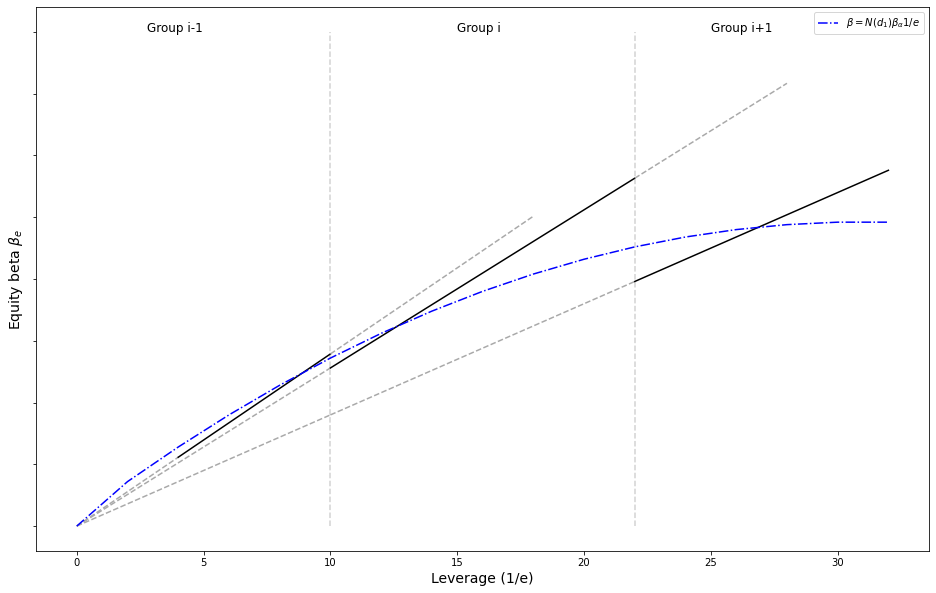

In [35]:
"""
Plotting the results
"""
fig, ax = plt.subplots(1, 1,figsize=(16,10))

#group i-1
ax.plot(line1[:3], beta1[:3], color='darkgrey', linestyle='--')
ax.plot(line1[2:6], beta1[2:6], color='black', linestyle='-')
ax.plot(line1[5:12], beta1[5:12], color='darkgrey', linestyle='--')

#group i
ax.plot(line2[:6], beta2[:6], color='darkgrey', linestyle='--')
ax.plot(line2[5:12], beta2[5:12], color='black', linestyle='-')
ax.plot(line2[11:17], beta2[11:17], color='darkgrey', linestyle='--')

#group i+1
ax.plot(line3[:6], beta3[:6], color='darkgrey', linestyle='--')
ax.plot(line3[5:12], beta3[5:12], color='darkgrey', linestyle='--')
ax.plot(line3[11:17], beta3[11:17], color='black', linestyle='-')

#option theory
ax.plot(np.arange(0,34,2), option, color='blue', label=r'$\beta = N(d_1) \beta_\alpha 1/e$', linestyle='-.')

ax.set_xlabel('Leverage (1/e)').set_fontsize(14)
ax.set_ylabel(r'Equity beta $\beta_e$').set_fontsize(14)
ax.vlines(10,0,2, color='lightgrey', linestyle='--')
ax.vlines(22,0,2, color='lightgrey', linestyle='--')
ax.text(2.75,2,'Group i-1').set_fontsize(12)
ax.text(15,2,'Group i').set_fontsize(12)
ax.text(25,2,'Group i+1').set_fontsize(12)
ax.set_yticklabels([])
ax.legend();